In [2]:
import numpy as np
import cv2
%matplotlib inline

from skimage import color
from skimage import io

from scipy import ndimage

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from PIL import Image


In [3]:
def crop_center(img,cropx,cropy):
    y,x = img.shape
    startx = x//2-(cropx//2)
    starty = y//2-(cropy//2)    
    return img[starty:starty+cropy,startx:startx+cropx]

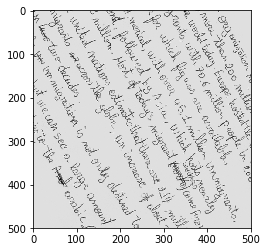

In [4]:
#Test importing and cropping image to center 

image = color.rgb2gray(mpimg.imread('data_prepared/1.png'))
plt.imshow(image, cmap='gray') # show image in grayscale

image = crop_center(image, 500, 500)
plt.imshow(image, cmap='gray') # show image in grayscale



In [5]:
def import_image_and_crop(datapath,crop_size=1000):
    ''' Read the image, convert it to grayscale, and use only the (crop_size x crop_size) center'''
    image = color.rgb2gray(mpimg.imread(datapath))
    assert(np.shape(image)[0]>crop_size and np.shape(image)[1]>crop_size),"Cant get center because image is too small"
    image = crop_center(image, crop_size, crop_size)
    return image

In [6]:
# import data

from os import listdir
from os.path import isfile, join
import random

crop_size = 138

onlyfiles = [f for f in listdir('data_prepared/') if isfile(join('data_prepared/', f))] # get list of datanames in folder

number_data = len(onlyfiles) - 1 # How many datafiles? One less because there is a list for the rotations
datanames = np.linspace(1,number_data,number_data)

X_train_pre = np.empty([number_data,crop_size,crop_size]) # create array to be filled, remember crop_size

for counter, number_of_file in enumerate(datanames):
    print(counter, end="\r")
    datapath = 'data_prepared/' + str(int(number_of_file))+'.png' # i know this is ugly
    X_train_pre[counter,:,:] = import_image_and_crop(datapath, crop_size)
    
    

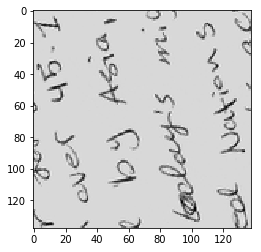

In [7]:
plt.imshow(X_train_pre[63,:,:], cmap='gray') # show image in grayscale, now squared and in the middle


In [8]:
# load angle list
Y_train_pre2 = np.loadtxt('data_prepared/angle_list.txt', delimiter=',', unpack=True)
Y_train_pre2.reshape((number_data,1))


array([[294.],
       [253.],
       [133.],
       ...,
       [ 76.],
       [128.],
       [128.]])

In [9]:
X_train_pre = X_train_pre.astype('float32')

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

X_train_pre = scaler.fit_transform(X_train_pre.reshape(X_train_pre.shape[0],crop_size*crop_size))

np.shape(X_train_pre)

(1900, 19044)

In [50]:
# own periodic loss function
from keras import backend as K
def mse_periodic(y_true, y_pred):
    diff = 180 - abs(abs(y_true - y_pred) - 180)
    return K.mean(K.square(diff), axis=-1)


In [82]:
# weird thingy 
shape_ord = (crop_size, crop_size, 1)

X_train_pre2 = X_train_pre


X_train_pre2 = X_train_pre2.reshape((X_train_pre2.shape[0],) + shape_ord)
X_train_pre2 = X_train_pre2.astype('float32')


from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten

from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D

# -- Initializing the values for the convolution neural network

nb_epoch = 30  # kept very low! Please increase if you can use a GPU

batch_size = 256
# number of convolutional filters to use
nb_filters = 16
# size of pooling area for max pooling
nb_pool = 4
# convolution kernel size
nb_conv = 3

model = Sequential()

model.add(Conv2D(nb_filters, kernel_size=(nb_conv, nb_conv), padding='valid', activation='relu', 
                 input_shape=shape_ord))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1))


model.compile(loss=mse_periodic, optimizer='adam')
          
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_26 (Conv2D)           (None, 136, 136, 16)      160       
_________________________________________________________________
dropout_8 (Dropout)          (None, 136, 136, 16)      0         
_________________________________________________________________
flatten_23 (Flatten)         (None, 295936)            0         
_________________________________________________________________
dense_54 (Dense)             (None, 64)                18939968  
_________________________________________________________________
dropout_9 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_55 (Dense)             (None, 1)                 65        
Total params: 18,940,193
Trainable params: 18,940,193
Non-trainable params: 0
________________________________________________________________

In [83]:
from sklearn.model_selection import train_test_split

X_train, X_val, Y_train, Y_val = train_test_split(X_train_pre2, Y_train_pre2, test_size=0.3, random_state=20)

In [ ]:
hist = model.fit(X_train, Y_train, batch_size=batch_size, 
                 epochs=nb_epoch, verbose=1, 
                 validation_data=(X_val, Y_val))

Train on 1330 samples, validate on 570 samples
Epoch 1/30
1330/1330 [==============================] - 7s 5ms/step - loss: 10750.9444 - val_loss: 10340.9111
Epoch 2/30
1330/1330 [==============================] - 6s 5ms/step - loss: 10549.2552 - val_loss: 10763.6012
Epoch 3/30
1330/1330 [==============================] - 6s 4ms/step - loss: 10469.7962 - val_loss: 10688.1018
Epoch 4/30
1330/1330 [==============================] - 6s 5ms/step - loss: 10481.8157 - val_loss: 10438.8542
Epoch 5/30
1330/1330 [==============================] - 6s 4ms/step - loss: 10552.3993 - val_loss: 10379.7684
Epoch 6/30
1330/1330 [==============================] - 6s 5ms/step - loss: 10395.2385 - val_loss: 10263.0837
Epoch 7/30
1330/1330 [==============================] - 6s 5ms/step - loss: 10451.4489 - val_loss: 10199.7084
Epoch 8/30
1330/1330 [==============================] - 6s 4ms/step - loss: 10383.4094 - val_loss: 10377.9210
Epoch 9/30
1330/1330 [==============================] - 6s 4ms/step - los

In [64]:
Y_pred = model.predict(X_val)
np.max(Y_pred)

46.46111